# Statistical Thinking in Python (Part 2)
- William Surles
- 2017-11-23
- Datacamp class
- [https://www.datacamp.com/courses/statistical-thinking-in-python-part-2](https://www.datacamp.com/courses/statistical-thinking-in-python-part-2)

## Whats Covered

**Parameter estimation by optimization**
- Optimal parameters
- Linear regression by least squares
- The importance of EDA: Anscombe's quartet

**Bootstrap confidence intervals**
- Generating bootstrap replicates
- Bootstrap confidence intervals
- Pairs bootstrap

**Introduction to hypothesis testing**
- Formulating and simulating a hypothesis
- Test statistics and p-values
- Bootstrap hypothesis tests

**Hypothesis test examples**
- A/B testing
- Test of correlation

**Putting it all together: a case study**
- Finch beaks and the need for statistics
- Variation of beak shapes
- Calculation of heritability
- Final thoughts

## Additional Resources

## Libraries and Data

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Useful Funcitons 

In [274]:

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def plot_ecdf(x,y, x_label = 'Number of Successes'):
    """Plot the ECDF for a one-dimensional array of measurements."""
        
#     plt.figure(figsize=(16,10))
    plt.plot(
        x, y,
        marker = 'o',
        markersize = 5,
        alpha = 0.7,
        linestyle = 'none')

    plt.margins(0.02)

    plt.xlabel(x_label)
    plt.ylabel('ECDF')

        
    return plt

def plot_hist_step(x, n_bins, x_label = 'Value'):
    """Plot the histogram for a one-dimensional array of measurements."""

    plt.figure(figsize=(16,10))
    plt.hist(
        x,
        bins = n_bins, 
        linewidth = 3,
        normed = True, 
        histtype = 'step')
    
    plt.xlabel(x_label)
    plt.ylabel('PDF')
    
    return plt

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]


# Parameter estimation by optimization

## Optimal parameters

- Parameter values that bring the model in closest agreement with the data
- The the case of michealsons speed of light data this is the actual mean and std from the dataset
- If your model is wrong, finding optimal parameters won't really matter much
- Finding the optimal parameters to model your data is not always as easy as just computing the mean and std
 - When we work with linear regressions later we will use built in numpy functions to find the optimal parameters for us
- There are some very useful tools in python for doing statistical inference
 - scipy.stats
 - statsmodels
- In this class however, we will use hacker statistics
 - This is like a swiss army knife of statistics
 - you can apply the principles to a wide variety of statistical problems

### How often do we get no-hitters?
- If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed. 
- The exponential distribution has a single parameter $\tau{}$
- The value of the parameter $\tau{}$ that makes the exponential distribution best match the data is the mean interval time (where tim is in units of number of games) between no hitters.

In [275]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/mlb_nohitters.csv'
no_hitters = pd.read_csv(file)
print(no_hitters.head())
print(no_hitters.tail())

       date  game_number winning_team losing_team winning_pitcher
0  18760715          140          NaN         NaN             NaN
1  18800612         1035          NaN         NaN             NaN
2  18800617         1046          NaN         NaN             NaN
3  18800819         1177          NaN         NaN             NaN
4  18800820         1179          NaN         NaN             NaN
         date  game_number winning_team losing_team  winning_pitcher
289  20150725       210250          PHI         CHN      Cole Hamels
290  20150812       210490          SEA         BAL  Hisashi Iwakuma
291  20150821       210610          HOU         LAN    Michael Fiers
292  20150830       210740          CHN         LAN     Jake Arrieta
293  20151003       211208          WAS         NYN     Max Scherzer


In [276]:
nohitter_times = no_hitters.game_number.diff(1)[1:]
nohitter_times[:6]

1    895.0
2     11.0
3    131.0
4      2.0
5    935.0
6     30.0
Name: game_number, dtype: float64

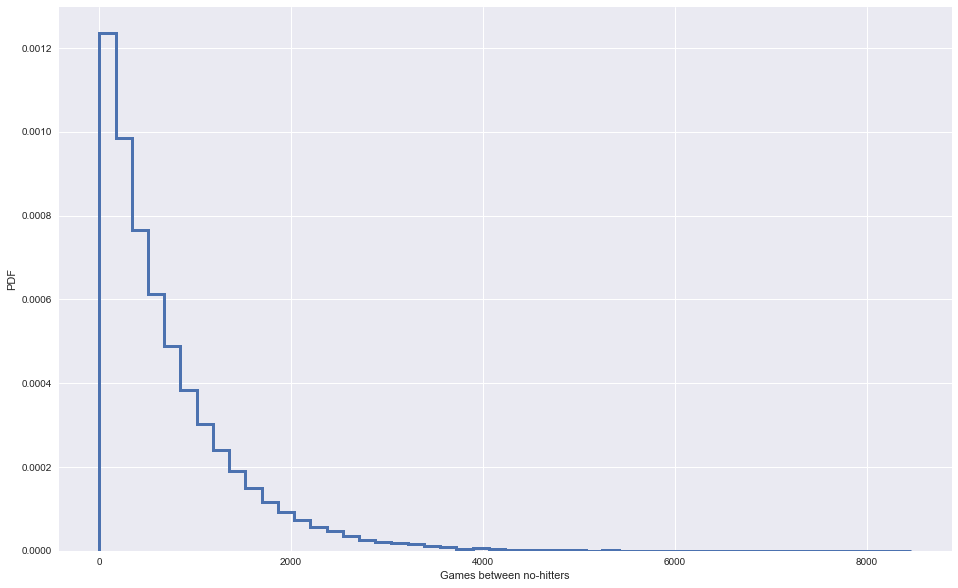

In [277]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100000)

# Plot the PDF and label axes
plot_hist_step(
    inter_nohitter_time, 
    n_bins = 50, 
    x_label = 'Games between no-hitters')

# Show the plot
plt.show()

### Do the data follow our story?

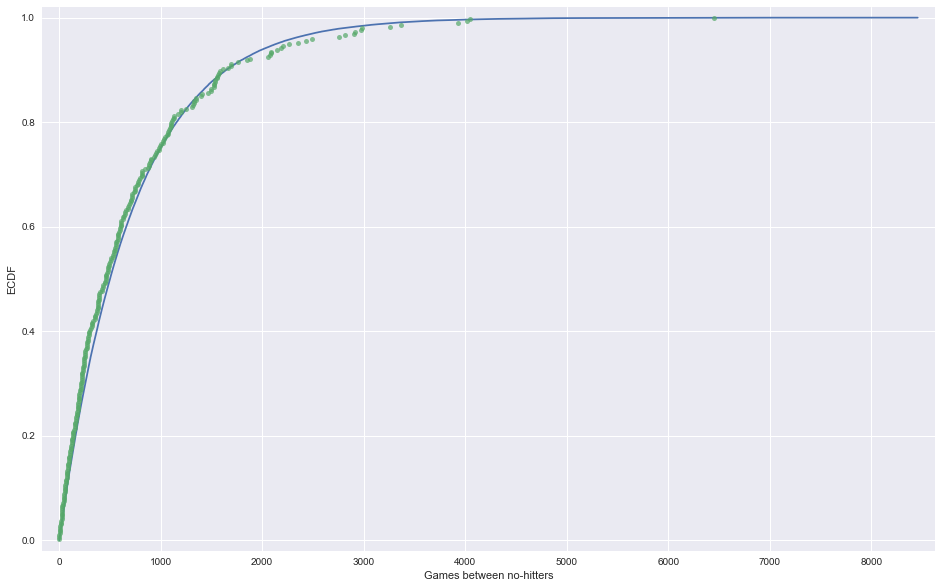

In [278]:
# Create an ECDF from real data: x, y
x, y = ecdf(nohitter_times)

# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

# Overlay the plots
plt.figure(figsize=(16,10))
plt.plot(x_theor, y_theor)
plot_ecdf(x,y, x_label = 'Games between no-hitters')


# Show the plot
plt.show()


### How is this parameter optimal?

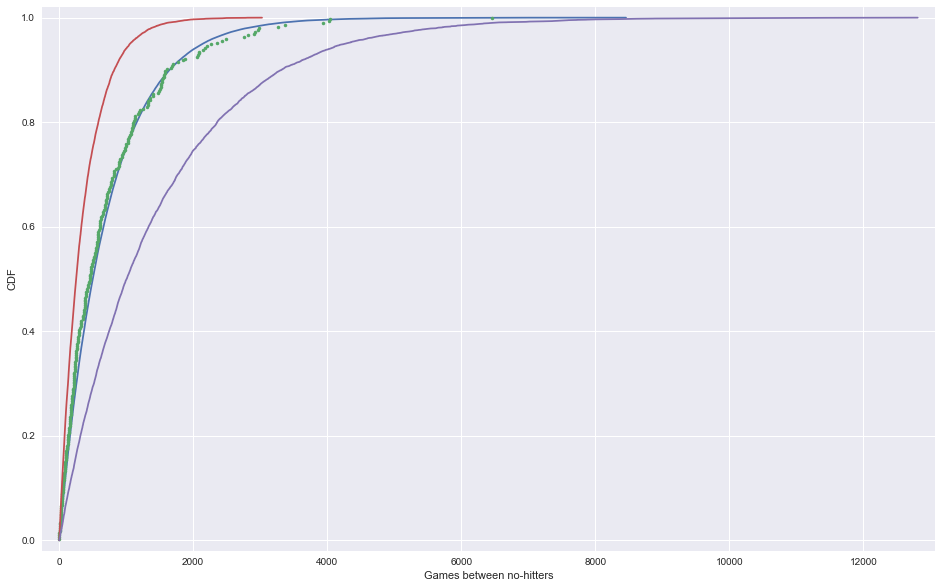

In [279]:
# Plot the theoretical CDFs
plt.figure(figsize=(16,10))
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')

# Take samples with half tau: samples_half
samples_half = np.random.exponential(tau/2, 10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(tau*2, 10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
_ = plt.plot(x_half, y_half)
_ = plt.plot(x_double, y_double)

# Show the plot
plt.show()

## Linear regression by least squares

- Sometimes, two variable are related. : ) Ha!
- We can calculate a pearsons value which is a good start. 
- But we can go further and actually get a sense of what one value will be based on another
- In this case we can fit a model to describe what the y value will be based on the x value
- A linear regression is a simple common form of this
 - We find the line through the points where the vertical difference between the line and each point is minimized. We square all the differences and move the line around till we find the smallest value. 
 - This is ordinary least squares regression. Its the most common I believe
- You define the line with the y intercept and slope
- the slope tells you how much the y value changes for each increase in value for x
 - Thats pretty useful. 

### EDA of literacy/fertility data

In [280]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/female_literacy_fertility.csv'
female = pd.read_csv(file)
female.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


In [281]:
illiteracy = 100 - female['female literacy']
fertility = female['fertility']

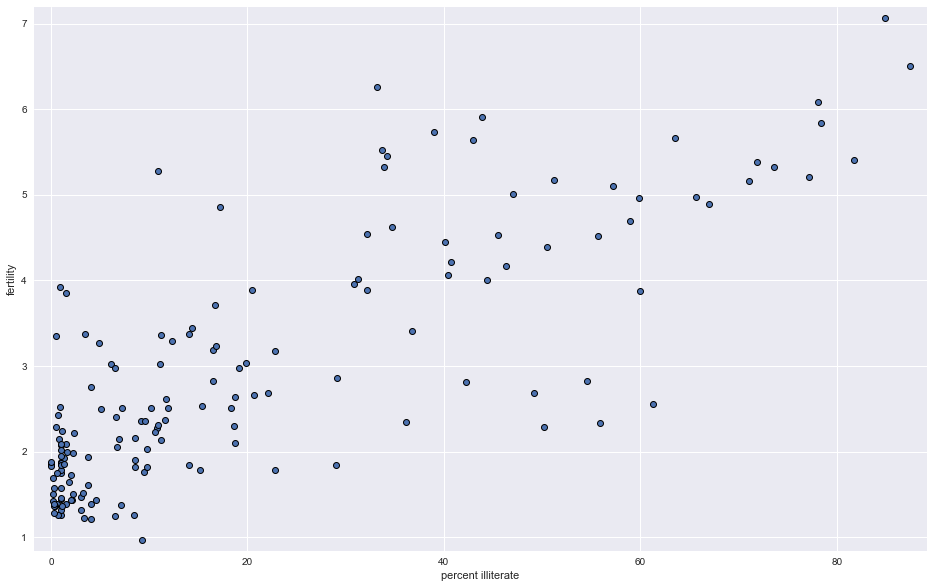

In [282]:
# Plot the illiteracy rate versus fertility
plt.figure(figsize=(16,10))
_ = plt.plot(
    illiteracy, fertility, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Show the plot
plt.show()

In [283]:
# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

0.804132402682


### Linear regression

slope = 0.0497985480906 children per woman / percent illiterate
intercept = 1.88805061064 children per woman


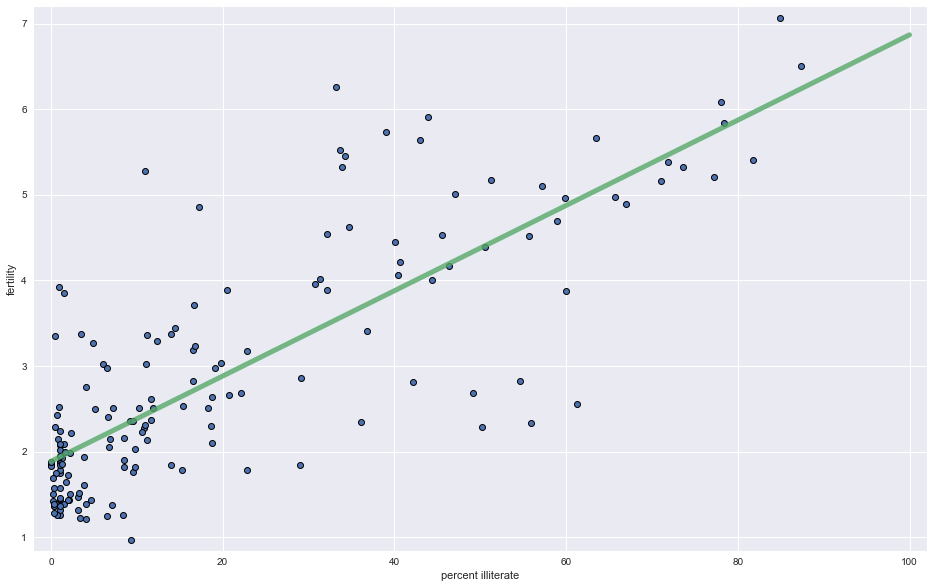

In [284]:
# Plot the illiteracy rate versus fertility
plt.figure(figsize=(16,10))
_ = plt.plot(
    illiteracy, fertility, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y, linewidth = 5, alpha = 0.8)

# Draw the plot
plt.show()


### How is it optimal?

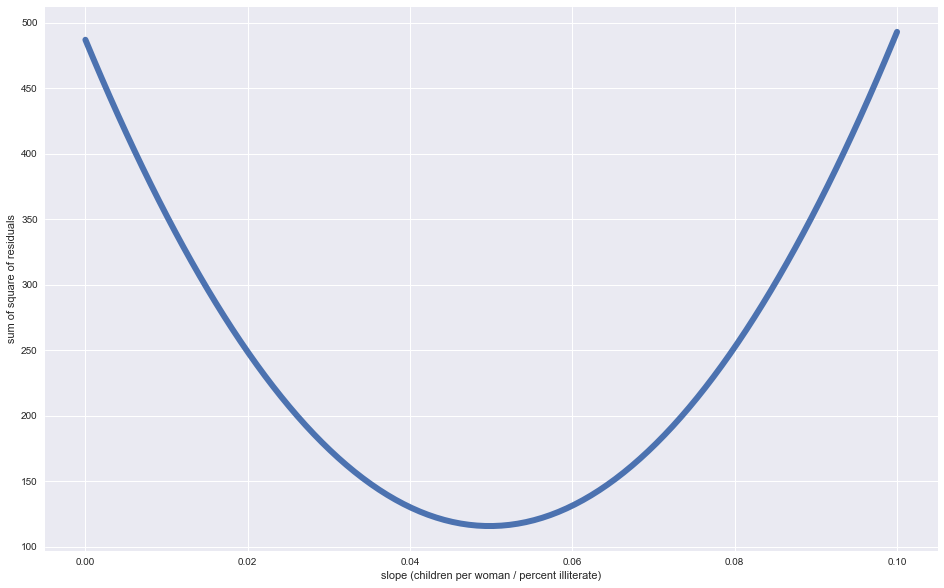

In [285]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((fertility - a*illiteracy - b)**2)

# Plot the RSS
plt.figure(figsize=(16,10))
plt.plot(a_vals, rss, '-', linewidth = 6)
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

plt.show()


## The importance of EDA: Anscombe's quartet

- Look before you leap
- In Anscombe's quartet there are 4 data sets that all have the same x mean, y mean, regression line fit, and squarred error. Its awesome.

![](images/anscombe.png)

### The importance of EDA

- EDA helps you plan the rest of your analysis
- Its also very helpful to prevent misinterpretation like that showed by the Anscombe quartet
- It gives you a great sense of your data and is not very hard to do eaither.
- I think its helpful for those whoe will be recieving your analysis to help them understand the data, question, analysis, and answer. 

### Linear regression on appropriate Anscombe data

In [286]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/anscombe.csv'
anscombe = pd.read_csv(file, skiprows = [0,1], names = ['x_0','y_0','x_1','y_1','x_2','y_2','x_3','y_3'])
anscombe.head()

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47


In [287]:
x = anscombe.x_0
y = anscombe.y_0

In [288]:
# Perform linear regression: a, b
a, b = np.polyfit(x,y,1)

# Print the slope and intercept
print(a, b)

0.500090909091 3.00009090909


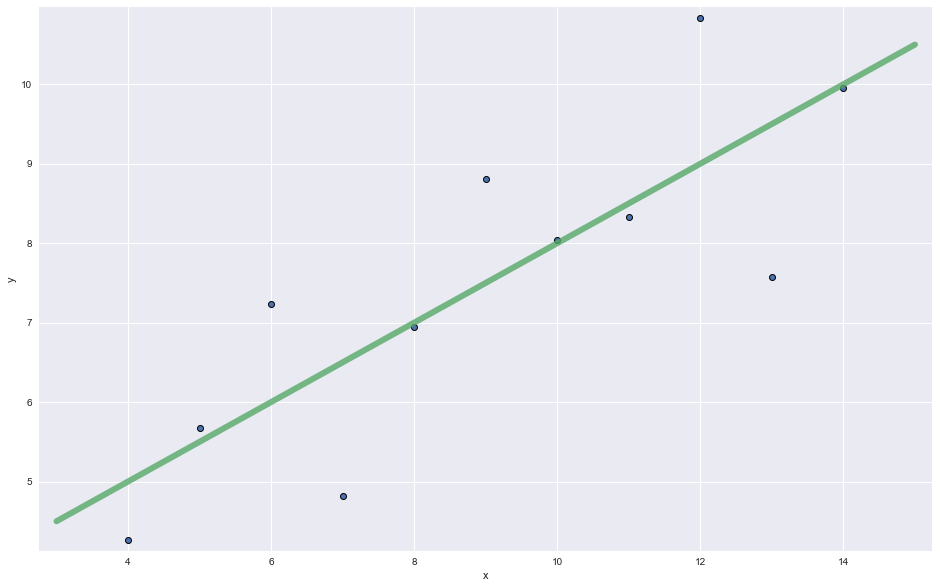

In [289]:
# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([3, 15])
y_theor = a * x_theor + b

# Plot the Anscombe data and theoretical line
plt.figure(figsize=(16,10))
_ = plt.plot(
    x, y, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

_ = plt.plot(x_theor, y_theor, linewidth = 6, alpha = 0.8)

# Label the axes
plt.xlabel('x')
plt.ylabel('y')
plt.margins(0.02)

# Show the plot
plt.show()

### Linear regression on all Anscombe data

In [290]:
anscombe_x = anscombe.iloc[:,[0,2,4,6]]
anscombe_y = anscombe.iloc[:,[1,3,5,7]]

In [291]:
# Iterate through x,y pairs
for x, y in zip(anscombe_x, anscombe_y):

    # Compute the slope and intercept: a, b
    a, b = np.polyfit(anscombe_x[x], anscombe_y[y], 1)

    # Print the result
    print('slope:', a, 'intercept:', b)


slope: 0.500090909091 intercept: 3.00009090909
slope: 0.5 intercept: 3.00090909091
slope: 0.499727272727 intercept: 3.00245454545
slope: 0.499909090909 intercept: 3.00172727273


# Bootstrap confidence intervals

## Generating bootstrap replicates

- you take a sample of measured data (like the speed of light from experiments)
- then you create a new **bootstrap sample** that is the same length of the original array
 - you sample a value at random from the original dataset and put it in the bootstrap sample
 - repeat this until the bootstrap sample is full
 - you do not delete the value from the original array once it is selected in the bootstrap sample (unless you are doing it "without" replacement. 
 - but this will just give you the same original array but in a random order.

### Getting the terminology down

- A bootsrap replicate is a single value of a statistic computed from a bootstrap resample. Like a mean
- Terminology is important. "Bootstrap" gets used in many ways in the coding community so be sure to define terminioloy when you are talking about these things.

### Bootstrapping by hand

- [-1, 0, 1]
- How many unique bootstrap samples can be drawn from this dataset. 
 - 27, because we use replacement 3 * 3 * 3
- What is the maximum mean you can get
 - 1 from [1, 1, 1]

### Visualizing bootstrap samples
- They use the speed of light data but I don't have access to that so I am just going to use rainfall
- Now i see that they use the rainfall data for their exercises so we will see this twice I guess. oh well

In [292]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/sheffield_weather_station.csv'
weather = pd.read_csv(file, sep = '\s+', skiprows = 8, index_col = 'yyyy', parse_dates = False)
# anscombe = pd.read_csv(file, skiprows = [0,1], names = ['x_0','y_0','x_1','y_1','x_2','y_2','x_3','y_3'])
weather.head()

,mm,tmax,tmin,af,rain,sun
yyyy,,,,,,
1883,1,6.3,1.7,6,122.1,---
1883,2,8.0,2.8,2,69.8,---
1883,3,4.8,-1.6,23,29.6,---
1883,4,12.2,3.8,2,74.0,---
1883,5,14.7,6.2,0,31.2,---


In [293]:
rainfall = weather.groupby('yyyy')['rain'].sum()

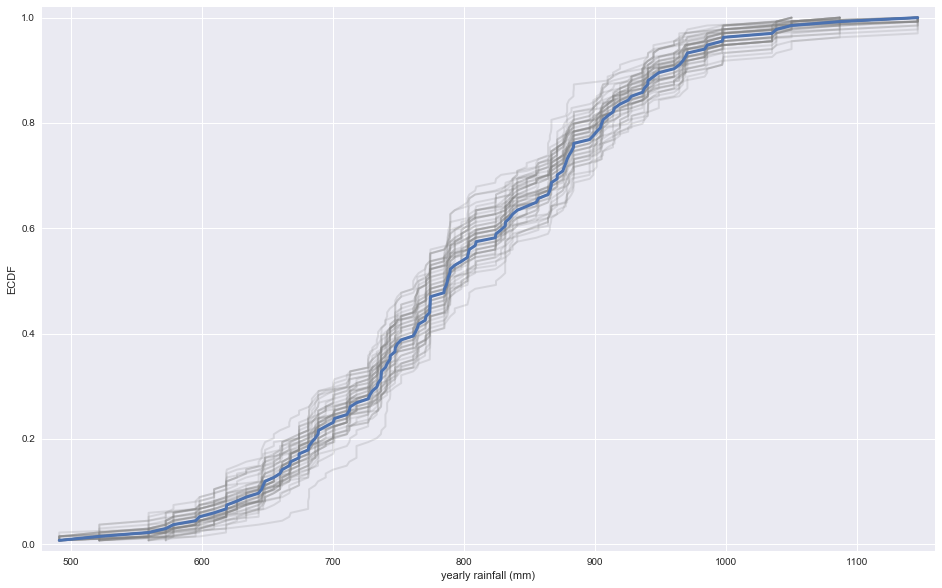

In [294]:
plt.figure(figsize=(16,10))

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(
        x, y, 
        linestyle='-',
        linewidth = 2,
        color='gray', 
        alpha=0.2)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, linewidth = 3)

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()


## Bootstrap confidence intervals

#### Bootstrap replicate function
 - this is pretty simple
 - just take a bootrap sample and compute the mean or median or any function for a stastic

In [295]:
def bootstrap_replicate_1d(data, func):
    """generate bootstrap replicate of 1D data"""
    
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [296]:
print(np.mean(rainfall))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))

798.014179104
797.264925373
803.085074627
801.694776119
806.364925373


#### Many bootstrap replicates

In [297]:
bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(rainfall, np.mean)

#### Ploting a histogram of bootstrap replicates

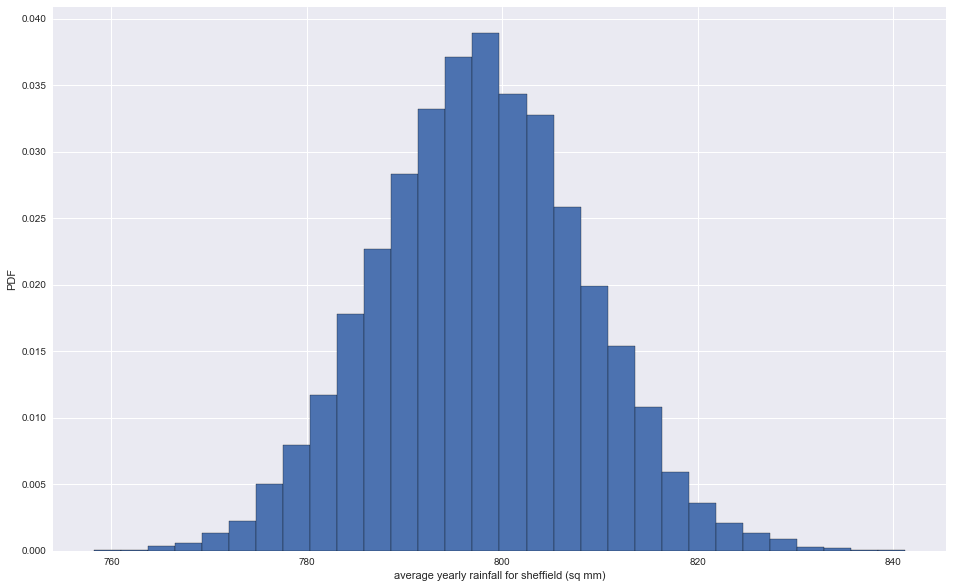

In [298]:
plt.figure(figsize=(16,10))
plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 30, 
    normed = True)
plt.xlabel('average yearly rainfall for sheffield (sq mm)')
plt.ylabel('PDF')
plt.show()

- So, from eying the pdf, if we were to capture the yearly rainfall for sheffield over and over again (which is something we cannot do becasuse we can't go back in time to rerun this experiment) we would expect to see a mean from 1983 to 2016 of say 798 +/- 20 inches. 
- Lets figure this out with a little more statistic rigor. What is the mean yearly rainfall for sheffield, for real?

#### Confidence interval of a statistic
- If we repeated measurements over and over agian, p% of the observed values would lie within the p% confidence interval. 
- In other words if we were run an experiment 100 times and take the mean, 95 of the mean values would be within the 95% confidence interval

In [299]:
mean = np.mean(bs_replicates)
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print("mean = " + str(mean))
print("95 % conf int = " + str(conf_int))
print('-----------------------')
print("So I would say I am 95% ceratin that the mean is... " + str(mean) + " +/- " + str((conf_int[1] - conf_int[0])/2) + " sq mm")

mean = 797.851752313
95 % conf int = [ 777.33192164  818.82936567]
-----------------------
So I would say I am 95% ceratin that the mean is... 797.851752313 +/- 20.7487220149 sq mm


### Generating many bootstrap replicates

In [300]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


### Bootstrap replicates of the mean and the SEM

10.6354581308
10.5930220051


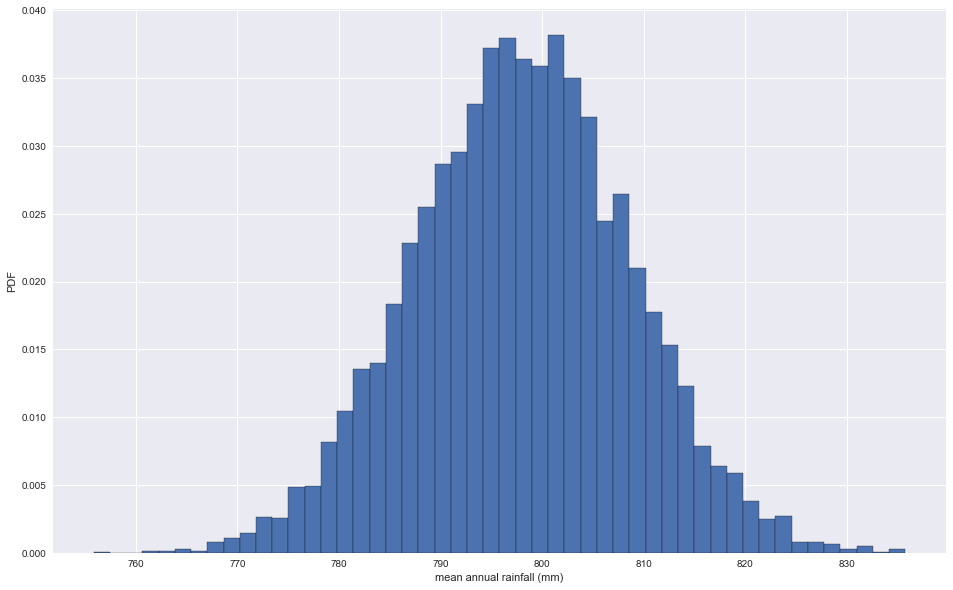

In [301]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
plt.figure(figsize=(16,10))
_ = plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Confidence intervals of rainfall data

In [302]:
np.percentile(bs_replicates, [2.5, 97.5])

array([ 777.16337687,  818.77761194])

### Bootstrap replicates of other statistics

- We saw in a previous exercise that the mean is Normally distributed. 
- This does not necessarily hold for other statistics
 - but no worry: as hackers, we can always take bootstrap replicates! 

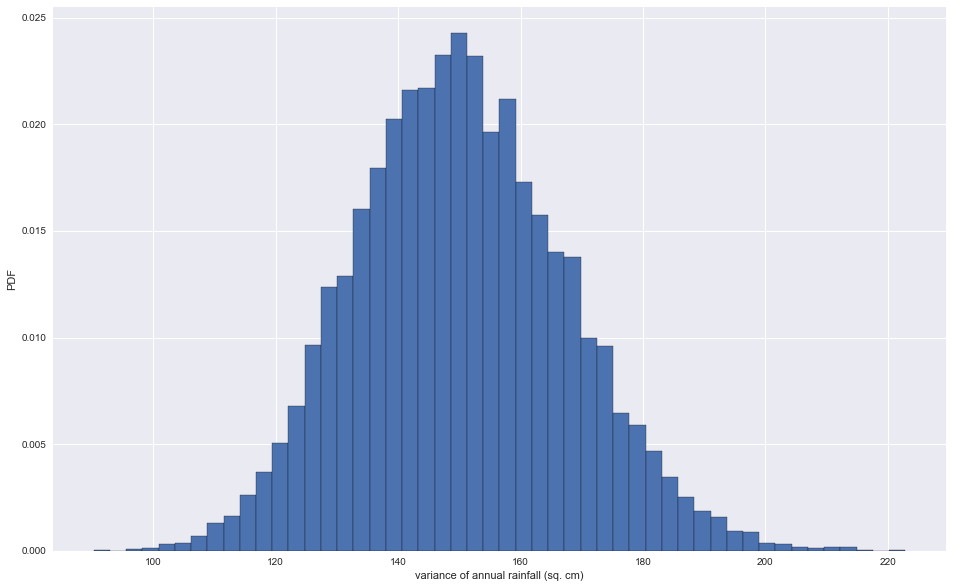

In [303]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=10000)

# Put the variance in units of square centimeters
bs_replicates /= 100

# Make a histogram of the results
plt.figure(figsize=(16,10))
_ = plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()


### Confidence interval on the rate of no-hitters

95% confidence interval = [ 628.20298635  817.49846416] games


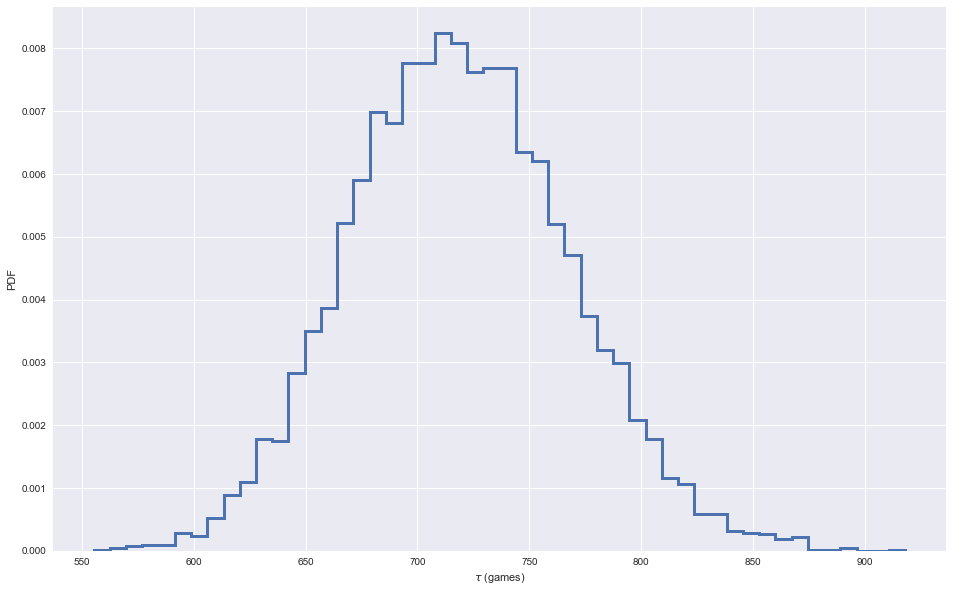

In [304]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
plot_hist_step(bs_replicates, n_bins = 50, x_label = r'$\tau$ (games)')

# Show the plot
plt.show()


## Pairs bootstrap

- We want to think probabilisticly about our linear model from before
- We can't resample voter number and obama percents separately, becasue the data are paired
- So we sample pairs, or the points basically
- Its pretty easy, we just sample the indicies of the dataframe or arrays

### A function to do pairs bootstrap

In [305]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


### Pairs bootstrap of literacy/fertility data

[ 0.0443521   0.05529943]


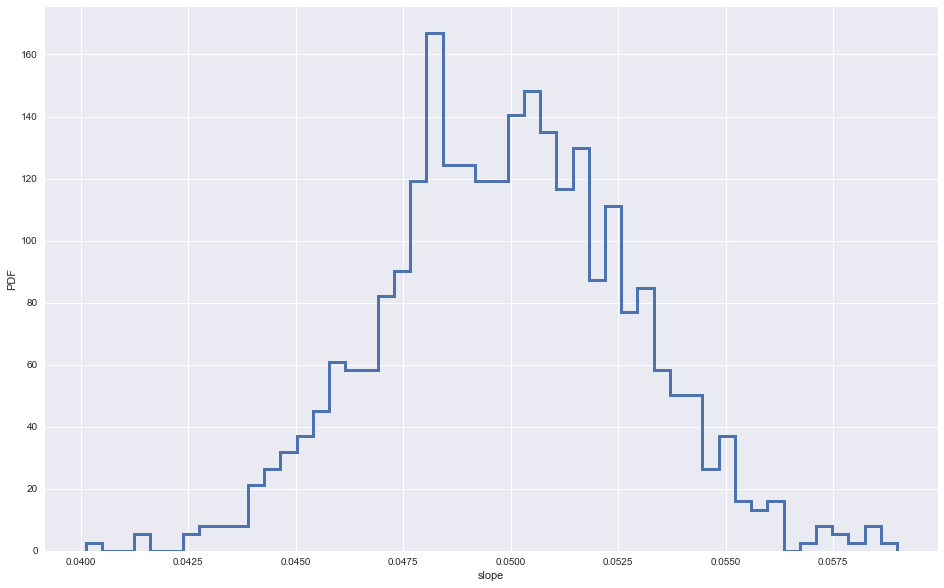

In [306]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, size = 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
plot_hist_step(bs_slope_reps, 50, 'slope')
plt.show()

### Plotting bootstrap regressions

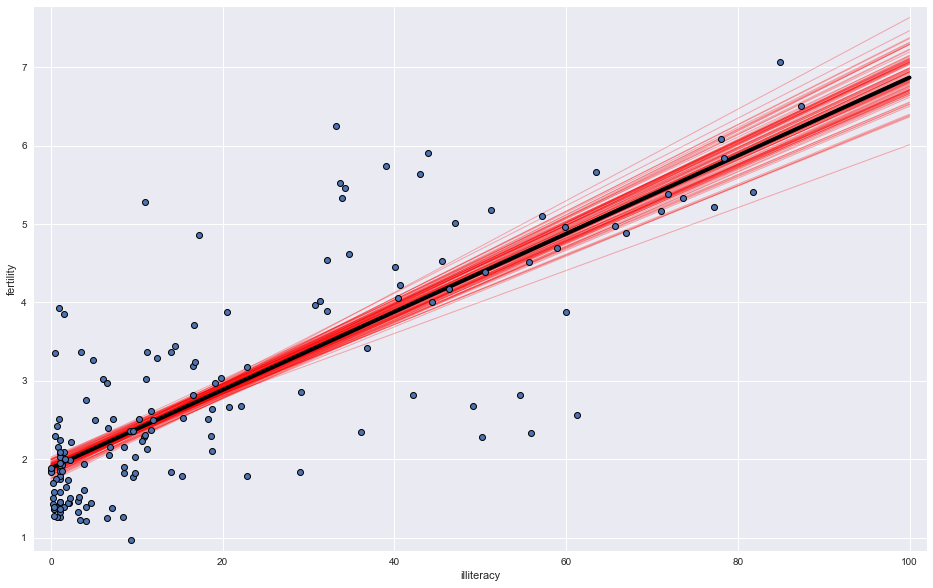

In [307]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

plt.figure(figsize=(16,10))

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(
        x, 
        bs_slope_reps[i]*x + bs_intercept_reps[i],
        linewidth=1, 
        alpha=0.3, 
        color='red')

# Plot the original regression line
# Make theoretical line to plot
a, b = np.polyfit(illiteracy, fertility, 1)
y = a * x + b

# Add regression line to your plot
_ = plt.plot(
    x, y,
    linewidth=4,  
    color='black')

# Plot the data
_ = plt.plot(
    illiteracy, fertility,
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

# Introduction to hypotheis testing

## Formulating and simulating a hypothesis

- Hypothesis testing
 - Assessment of how reasonabole the observed data are assiming a hypthesis is true
- Null Hypothesis
 - Another name for the hypothesis you are testing
- The hypthesis the instructor makes
 - Ohio and Pennsylvania have the same normal distribution
 - Looking at the ecdf they definitely look close
 - same for summary statistics
- But to know for sure we can re-simulate the election with scrambled values between the two labels
 - They call this 'permutation'
 - We will cover how to generate a permutation sample
 - I have seen this called 'shuffling' before
 

### Generating a permutation sample
- Remember, a permutation sample of two arrays having respectively n1 and n2 entries is constructed by: 
 - concatenating the arrays together, 
 - scrambling the contents of the concatenated array, 
 - and then taking the first n1 entries as the permutation sample of the first array 
 - and the last n2 entries as the permutation sample of the second array.

In [308]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

### Visualizing permutation sampling

In [309]:
weather.head(24)

,mm,tmax,tmin,af,rain,sun
yyyy,,,,,,
1883,1,6.3,1.7,6,122.1,---
1883,2,8.0,2.8,2,69.8,---
1883,3,4.8,-1.6,23,29.6,---
1883,4,12.2,3.8,2,74.0,---
1883,5,14.7,6.2,0,31.2,---
1883,6,17.7,9.3,0,66.2,---
1883,7,18.8,10.5,0,77.6,---
1883,8,19.8,10.9,0,32.5,---
1883,9,16.8,10.0,0,137.4,---


In [310]:
rain_july = weather.rain[weather.mm == 7]
rain_november = weather.rain[weather.mm == 11]

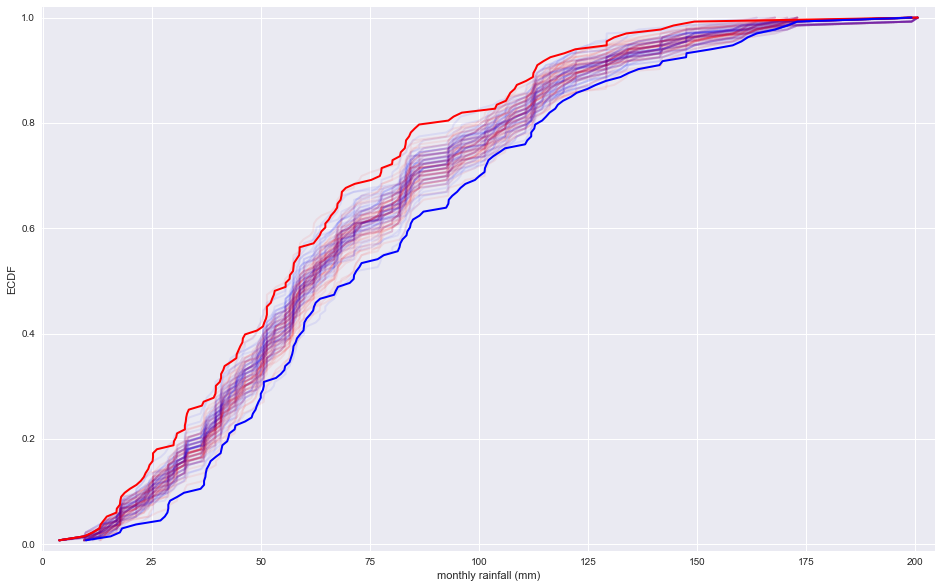

In [311]:
plt.figure(figsize=(16,10))

for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_july, rain_november)

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(
        x_1, y_1, 
        linestyle='-',
        linewidth = 2,
        color='red', 
        alpha=0.07)
    
    _ = plt.plot(
        x_2, y_2, 
        linestyle='-',
        linewidth = 2,
        color='blue', 
        alpha=0.07)
    
# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_july)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, linestyle='-', linewidth = 2, color='red')
_ = plt.plot(x_2, y_2, linestyle='-', linewidth = 2, color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()

## Test statistics and p-values

- So is the rain fall in the two months (july and november) differnet?
 - Or is the percent vote for obama by county different in Ohio and Penn?
- To answer this concretely we will use a hypothesis test on a test statistic, like the mean
- test statistic
 - A single number that can be computed from observed data and form data you simulate under the null hypothesis
 - It serves as a basis of comparison between the two
- p-value
 - The probability of obtaining a value of your test statistic that is at least as extreme as what was observed, under the the assumption the null hypothesis is true
 - NOT the prbability that the null hypothesis is true

For me, this is all much easier to understand when I see it
- Basically we make a hypthesis that rainfall in july and november is different
- then we say the null hypothesis is that they are the same
- then we run a bunch of samples assumping the the null hypothesis is true. 
 - i.e. we shuffle labels and measure the statistic, 
 - or in this case, the difference in the statistic, so the differnece in means between the two shuffled samples
- then we see how often we get a test statistic more extreme than what we had from the original samples
 - if its less than .05 percent of the time then we reject the null hypothesis, which is just to say. we accept the hypothesis that the original samples come from different distributions. 
 - so yeah, it rains more in november. : ) 
 - the 0.05 can be whatever, thats just a classic place to draw the line.
- anyways, lets just do it

### Test statistics

- When performing hypothesis tests, your choice of test statistic should be:
 - pertinent to the question you are seeking to answer in your hypothesis test.

### What is a p-value?

- The p-value is generally a measure of:
 - the probability of observing a test statistic equally or more extreme than the one you observed, assuming the hypothesis you are testing is true.

### Generating permutation replicates

In [312]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

### Look before you leap: EDA before hypothesis testing

In [313]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/frog_tongue.csv'
df = pd.read_csv(file, skiprows = 14)
df.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


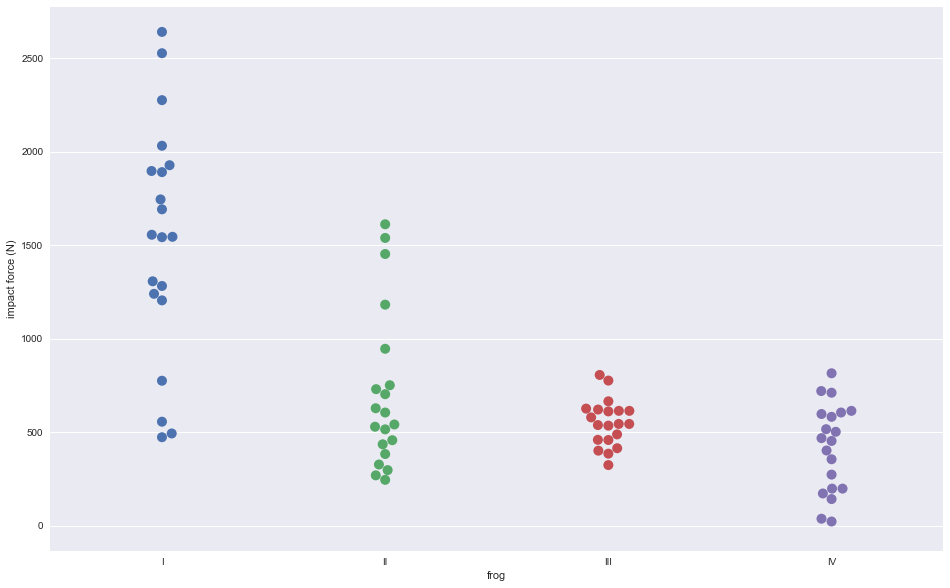

In [314]:
plt.figure(figsize=(16,10))

# Make bee swarm plot
_ = sns.swarmplot(
    x = 'ID', 
    y = 'impact force (mN)', 
    data = df,
    size = 10)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


### Permutation test on frog data

In [315]:
force_a = df['impact force (mN)'][df['ID'] == 'II']
force_b = df['impact force (mN)'][df['ID'] == 'IV']

In [316]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.004


- This is pretty small suggesting that the populations are different
 - Its not totally out there, like 0.0000000005
 - but enough for us to say adult frogs have stronger tounges than adolesent frogs
- I think it helps to show the distribution so let me try to do that. 

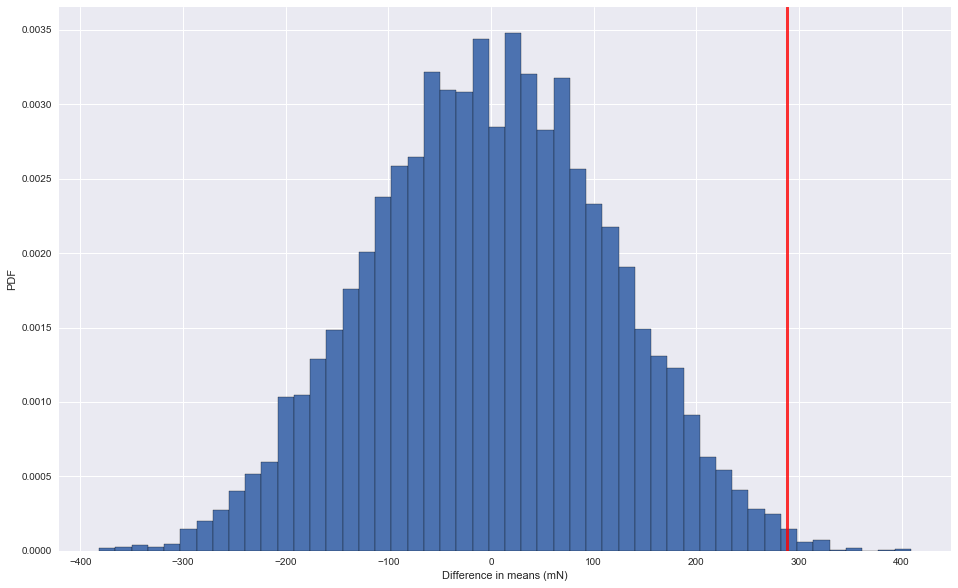

In [317]:
# Make a histogram of the results
plt.figure(figsize=(16,10))
plt.hist(
    perm_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)
plt.axvline(x=empirical_diff_means, color = 'red', linewidth = 3, alpha = .8)
plt.xlabel('Difference in means (mN)')
plt.ylabel('PDF')
plt.show()

## Bootstrap hypothesis tests

#### Pipeline for hypothesis testing
- Clearly state the null hypothesis
- Define your test statistic
- Generate many sets of simulated data assuming the null hypothesis is true
- Compute the test statistic for each simulated data set
- The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data


In [318]:
file = 'https://assets.datacamp.com/production/course_1549/datasets/michelson_speed_of_light.csv'
light = pd.read_csv(file)
light.head()

,Unnamed: 0,date,distinctness of image,temperature (F),position of deflected image,position of slit,displacement of image in divisions,difference between greatest and least,B,Cor,revolutions per second,radius (ft),value of one turn of screw,velocity of light in air (km/s),remarks
0,0,June 5,3,76,114.85,0.300,114.55,0.17,1.423,-0.132,257.36,28.672,0.99614,299850,Electric light.
1,1,June 7,2,72,114.64,0.074,114.56,0.10,1.533,-0.084,257.52,28.655,0.99614,299740,P.M. Frame inclined at various angles
2,2,June 7,2,72,114.58,0.074,114.50,0.08,1.533,-0.084,257.52,28.647,0.99614,299900,P.M. Frame inclined at various angles
3,3,June 7,2,72,85.91,0.074,85.84,0.12,1.533,-0.084,193.14,28.647,0.99598,300070,P.M. Frame inclined at various angles
4,4,June 7,2,72,85.97,0.074,85.89,O.07,1.533,-0.084,193.14,28.650,0.99598,299930,P.M. Frame inclined at various angles


In [319]:
speed_of_light = light['velocity of light in air (km/s)']
speed_of_light[:6]

0    299850
1    299740
2    299900
3    300070
4    299930
5    299850
Name: velocity of light in air (km/s), dtype: int64

In [320]:
mean = np.mean(speed_of_light)
print(mean)

299852.4


#### Comparing Michelson and Newcomb: speed of light pioneers
- Michelson's mean = 299,852
- Newcomb's mean = 299,860
- Thats a differnce of 8 km/s
- Also, newcomb did share his data. (I guess he hadn't hear of reproducible research yet)

#### Our Null Hypothesis
- The true mean speed of light in Michelson's experiments was actually Newcomb's reported value
- To test this we will shift michelson's data so the mean is the same as newcomb's
 - Then we will simulate a bunch of samples and see if getting 299852 is likely or not. 

#### Shifting the Michelson data

In [321]:
newcomb_value = 299860
michelson_shifted = speed_of_light - np.mean(speed_of_light) + newcomb_value

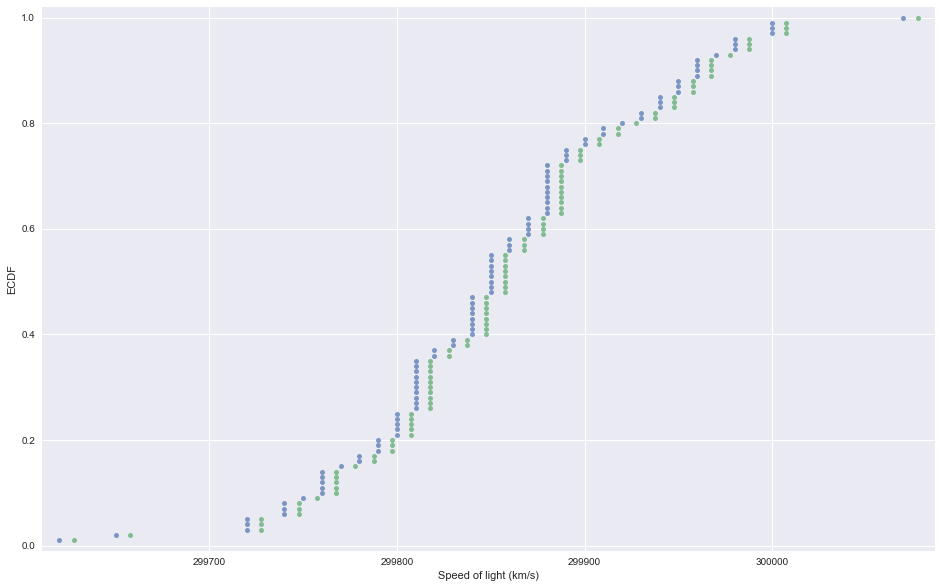

In [322]:
x_orig, y_orig = ecdf(speed_of_light)
x_shift, y_shift = ecdf(michelson_shifted)

plt.figure(figsize=(16,10))

plot_ecdf(x_orig, y_orig, 'Speed of light (km/s)')
plot_ecdf(x_shift, y_shift, 'Speed of light (km/s)')

# Make margins and label axes
plt.margins(0.02)
plt.xlabel('Speed of light (km/s)')
plt.ylabel('ECDF')

# Show the plot
plt.show()


#### Calculating the test statistic
- So this is just the differnce in means from our our speed of light data and the shifted dataset

In [323]:
def diff_from_newcomb(data, newcomb_value = 299860):
    return np.mean(data) - newcomb_value

diff_obs = diff_from_newcomb(speed_of_light)

diff_obs

-7.5999999999767169

#### Computing the p-value
- We will simulate 10000 samples from the null hypothesis dataset
- we will calculate the test statistic for each bootsrap sample
- we will calculate the p-value of the test statistic

In [324]:
bs_replicates = draw_bs_reps(michelson_shifted, diff_from_newcomb, 10000)

p_value = np.sum(bs_replicates <= diff_obs) / 10000
p_value

0.16700000000000001

#### Lets visualize this

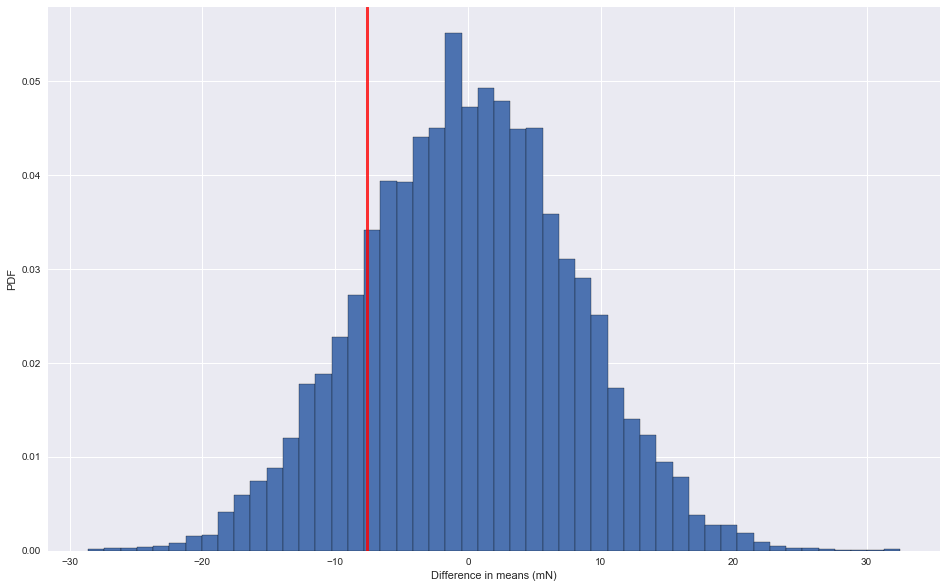

In [325]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)

plt.axvline(
    x = diff_obs, 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.xlabel('Difference in means (mN)')
plt.ylabel('PDF')
plt.show()

#### Conclusion
- Thats not very unlikely
- We can conclude that the mean of Michelsons data did not differ from the mean of Newcombs data
- I think that because we don't have newcombs data we can't actually make claims about them coming from the same population. 
 -I'm not exactly sure yest how that statics jargon works

#### One vs Two sample test
- One sample test
 - compare one set of data to a single number
 - This is what we just did
- Two sample test
 - Compare two sets of data

### A one-sample bootstrap hypothesis test
- Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces.  
 - Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. 
 - Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. 
 - You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.
- To set up the bootstrap hypothesis test, you will take the mean as our test statistic. 
- Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B _if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true._ 
- You first translate all of the data of Frog B such that the mean is 0.55 N. 
 - This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. 
 - This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [326]:
np.mean(force_b)

419.10000000000002

In [327]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 550
translated_force_b

60    302.9
61    272.9
62    167.9
63    583.9
64    485.9
65    152.9
66    632.9
67    403.9
68    850.9
69    712.9
70    328.9
71    328.9
72    727.9
73    646.9
74    945.9
75    532.9
76    735.9
77    841.9
78    744.9
79    598.9
Name: impact force (mN), dtype: float64

In [328]:
# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)
bs_replicates[:6]

array([ 439.25,  534.55,  489.55,  566.4 ,  568.25,  547.75])

In [329]:
# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)

p =  0.0052


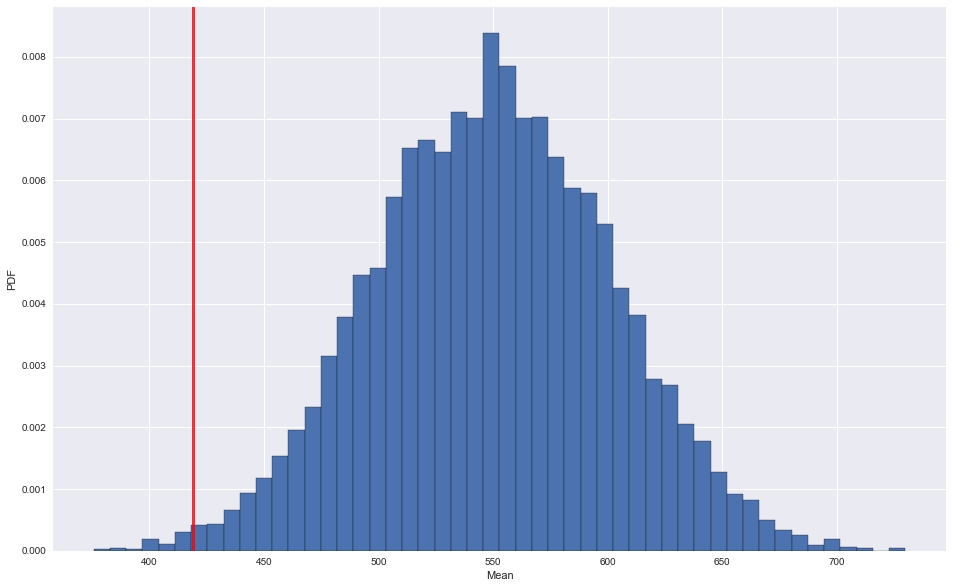

In [330]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)

plt.axvline(
    x = np.mean(force_b), 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.xlabel('Mean')
plt.ylabel('PDF')
plt.show()

### A bootstrap test for identical distributions

In [331]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Concatenate forces: forces_concat
forces_concat = np.concatenate([force_a, force_b])

# Initialize bootstrap replicates: bs_replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(
        forces_concat, 
        size=len(forces_concat))
    
    # Compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(force_a)],
                                     bs_sample[len(force_a):])

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0065


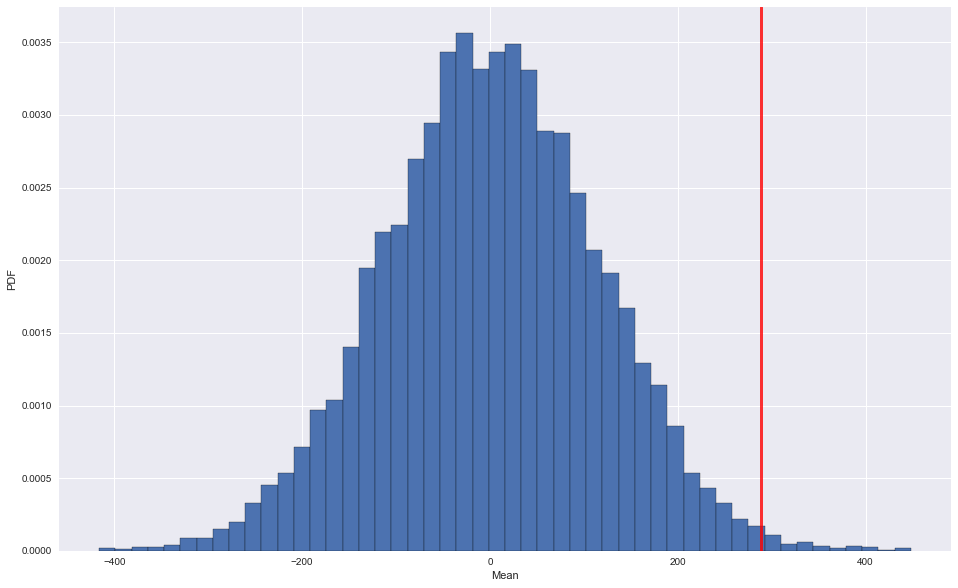

In [332]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)

plt.axvline(
    x = empirical_diff_means, 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.xlabel('Mean')
plt.ylabel('PDF')
plt.show()

- Great work! 
- You may remember that we got p = 0.0051 from the permutation test, and here we got p = 0.0067. 
- These are very close, and indeed the tests are testing the same thing. 
- However, the permutation test exactly simulates the null hypothesis that the data come from the same distribution, whereas the bootstrap test approximately simulates it. 
- As we will see, though, the bootstrap hypothesis test, while approximate, is more versatile.

### A two-sample bootstrap hypothesis test for difference of means.

**What the difference between shuffling (permutation) and bootstrapping**
- You performed a one-sample bootstrap hypothesis test, which is impossible to do with permutation. 
- Testing the hypothesis that two samples have the same distribution may be done with a bootstrap test, but a permutation test is preferred because it is more accurate (exact, in fact). 
- But therein lies the limit of a permutation test; it is not very versatile. 
- We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution. 
- This, too, is impossible with a permutation test.

**How we do a bootstrap test of the means being different**
- To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. 
- We then draw bootstrap samples out of the shifted arrays and compute the difference in means. 
- This constitutes a bootstrap replicate, and we generate many of them. 
- The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [333]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0055


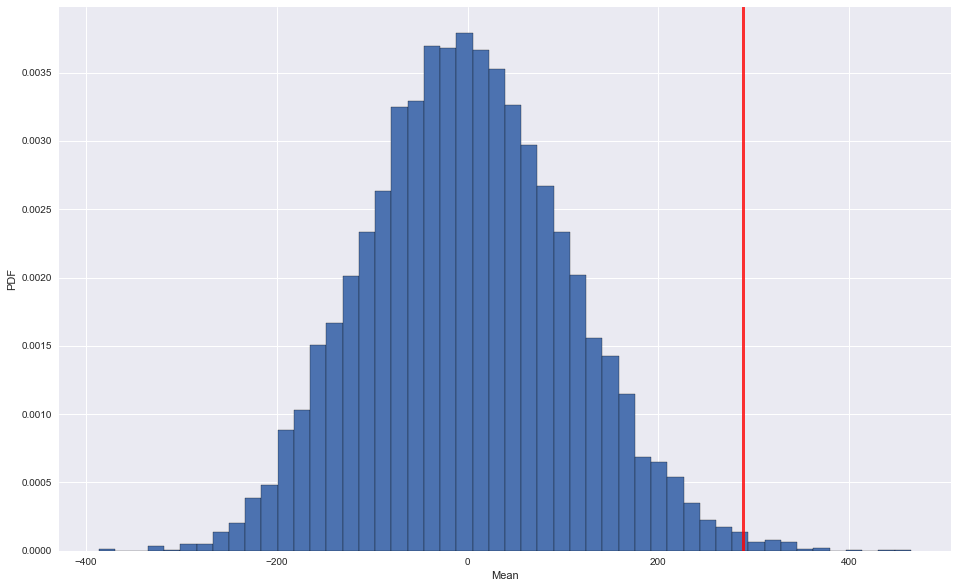

In [334]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)

plt.axvline(
    x = empirical_diff_means, 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.xlabel('Mean')
plt.ylabel('PDF')
plt.show()

 - Not surprisingly, the more forgiving hypothesis, only that the means are equal as opposed to having identical distributions, gives a smaller p-value. 
 - Again, it is important to carefully think about what question you want to ask. 
 - Are you only interested in the mean impact force, or the distribution of impact forces?

# Hypothesis test examples

## A/B testing

### The vote for the Civil Rights Act in 1964

### What is equivalent?

### A time-on-website analog

### What should you have done first?

## Test of correlation

### Simulating a null hypothesis concerning correlation

### Hypothesis test on Pearson correlation

### Do neonicotinoid insecticides have unintended consequences?

### Bootstrap hypothesis test on bee sperm counts

# Putting it all together: a case study

## Finch beaks and the need for statistics

### EDA of beak depths of Darwin's finches

### ECDFs of beak depths

### Parameter estimates of beak depths

### Hypothesis test: Are beaks deeper in 2012?

## Variation of beak shapes

### EDA of beak length and depth

### Linear regressions

### Displaying the linear regression results

### Beak length to depth ratio

### How different is the ratio?

## Calculation of heritability

### EDA of heritability

### Correlation of offspring and parental data

### Pearson correlation of offspring and parental data

### Measuring heritability

### Is beak depth heritable at all in *G. scandens*?

## Final thoughts